In [50]:
import numpy as np
import pandas as pd
import glob
from pathlib import Path
import cv2
import shutil
from zipfile import ZipFile
import matplotlib.pyplot as plt

In [23]:
def read_calib_file(filepath):
    """
    Read in a calibration file and parse into a dictionary.
    Ref: https://github.com/utiasSTARS/pykitti/blob/master/pykitti/utils.py
    """
    data = {}
    with open(filepath, 'r') as f:
        for line in f.readlines():
            line = line.rstrip()
            if len(line) == 0: continue
            key, value = line.split(':', 1)
            # The only non-float values in these files are dates, which
            # we don't care about anyway
            try:
                data[key] = np.array([float(x) for x in value.split()])
            except ValueError:
                pass

    return data

def load_velo_scan(velo_filename):
    scan = np.fromfile(velo_filename, dtype=np.float32)
    scan = scan.reshape((-1, 4))
    return scan

def project_velo_to_cam2(calib):
    P_velo2cam_ref = np.vstack((calib['Tr_velo_to_cam'].reshape(3, 4), np.array([0., 0., 0., 1.])))  # velo2ref_cam
    R_ref2rect = np.eye(4)
    R0_rect = calib['R0_rect'].reshape(3, 3)  # ref_cam2rect
    R_ref2rect[:3, :3] = R0_rect
    P_rect2cam2 = calib['P2'].reshape((3, 4))
    proj_mat = P_rect2cam2 @ R_ref2rect @ P_velo2cam_ref
    return proj_mat

def project_to_image(points, proj_mat):
    """
    Apply the perspective projection
    Args:
        pts_3d:     3D points in camera coordinate [3, npoints]
        proj_mat:   Projection matrix [3, 4]
    """
    num_pts = points.shape[1]

    # Change to homogenous coordinate
    points = np.vstack((points, np.ones((1, num_pts))))
    points = proj_mat @ points
    points[:2, :] /= points[2, :]
    return points[:2, :]

def prepare_lidar(pts_velo, calib, img_width, img_height):
    # projection matrix (project from velo2cam2)
    proj_velo2cam2 = project_velo_to_cam2(calib)

    # apply projection
    pts_2d = project_to_image(pts_velo.transpose(), proj_velo2cam2)
    #print(pts_2d.shape, pts_velo.shape, proj_velo2cam2.shape)

    # Filter lidar points to be within image FOV
    inds = np.where((pts_2d[0, :] < img_width) & (pts_2d[0, :] >= 0) &
                    (pts_2d[1, :] < img_height) & (pts_2d[1, :] >= 0) &
                    (pts_velo[:, 0] > 0)
                    )[0]

    # Filter out pixels points
    imgfov_pc_pixel = pts_2d[:, inds]

    # Retrieve depth from lidar
    imgfov_pc_velo = pts_velo[inds, :]
    imgfov_pc_velo = np.hstack((imgfov_pc_velo, np.ones((imgfov_pc_velo.shape[0], 1))))
    imgfov_pc_cam2 = proj_velo2cam2 @ imgfov_pc_velo.transpose()
    
    return imgfov_pc_pixel, imgfov_pc_cam2



In [35]:
def get_upper_body_rectangle(bbox, sub_bb_scale, start_x_scale, start_y_scale):
    """
    convert bbox yo in:
    [x, y, width, height]
    """
    sub_width = int(bbox[2] * sub_bb_scale)
    sub_height = int(bbox[3] * sub_bb_scale)
    return np.array([int(bbox[0]+(bbox[0]*start_x_scale)), int(bbox[1]+(bbox[1]*start_y_scale)), sub_width, sub_height])

In [37]:
def project_to_upper_bodies(pc_pixel, pc_cam2, upper_body):
    
    imgfov_pc_pixel = pc_pixel
    imgfov_pc_cam2 = pc_cam2

    
    lidars = np.zeros(shape=(3, 1))
    
    np_upper_body = np.array(upper_body).reshape(1, 4).flatten()

    upper_left = np_upper_body[0:2]
    lower_right = np_upper_body[0:2] + np_upper_body[2:4]

    box_indices = np.where((imgfov_pc_pixel[0, :] > upper_left[0]) & (imgfov_pc_pixel[0, :] < lower_right[0])&
                          (imgfov_pc_pixel[1, :] > upper_left[1])&(imgfov_pc_pixel[1, :] < lower_right[1]))[0]

    projected_points = imgfov_pc_pixel[0:2, box_indices]
    lidars = np.append(projected_points, imgfov_pc_cam2[2:3, box_indices], axis=0)
        
    return lidars

In [24]:
gt_files = sorted(glob.glob("/home/eam/MasterThesis/Thesis/TrackEval/data/gt/kitti_lidar/kitti_2d_box_train/label_02/*.txt"))
frames_root = ""
lidars_root = ""
lidar_zip_file = "/home/eam/KittiDs/data_tracking_velodyne.zip"
base_folder = "training/velodyne/"
extract_lidar_folder = "/home/eam/KittiDs/tmp"

In [25]:
bbox_scales = [(1/4,0,0), (1/4,1/4,0), (1/4,2/4,0), (1/4,3/4,0), 
          (1/4,0,1/4), (1/4,1/4,1/4), (1/4,2/4,1/4), (1/4,3/4,1/4),
         (1/4,0,2/4), (1/4,1/4,2/4), (1/4,2/4,2/4), (1/4,3/4,2/4),
         (1/4,0,3/4), (1/4,1/4,3/4), (1/4,2/4,3/4), (1/4,3/4,3/4)]

In [41]:
all_depthes = []
for gt_file in gt_files:
    sub_ds_name = gt_file.split("/")[-1].replace(".txt", "")
    sub_ds_path = sub_ds_name + "/" + sub_ds_name
    
    imgs = glob.glob(f"/home/eam/KittiDs/data_tracking_image_2/training/image_02/{sub_ds_name}/*.png")
    imgs = sorted(imgs)
    # read lidar points data
    shutil.rmtree(extract_lidar_folder)
    with ZipFile(lidar_zip_file, 'r') as zipObj:
        files = zipObj.namelist()
        for file in files:
            if file.startswith(base_folder+sub_ds_name):
                zipObj.extract(file, extract_lidar_folder)

    # read calibration file
    calib = read_calib_file(f'/home/eam/KittiDs/data_tracking_calib/training/calib/{sub_ds_name}.txt')

    velodyne_pah = f"{extract_lidar_folder}/training/velodyne/{sub_ds_name}"
    velo_path = Path(velodyne_pah)
    velo_frames = velo_path.glob("*.bin")
    velo_frames = [str(x) for x in sorted(velo_frames)]
    
    with open(gt_file, "r") as f:
        lines = f.readlines()
        for line in lines:
            splitted = line.split(" ")
            if splitted[2] == "Pedestrian":
                frame_num = int(splitted[0])
                _id = int(splitted[1])
                actual_depth = float(splitted[-2])
                #read img
                img_path = imgs[frame_num]
                frame = cv2.imread(img_path)
                
                # read bbox
                bbox = np.rint(np.array(list(map(float, splitted[-11:-7])))).astype(int)
                bbox = np.array([*bbox[0:2],*(bbox[2:4]-bbox[0:2])])
                
                # prepare LIDAR
                height, width, channel = frame.shape
                velo_points = load_velo_scan(velo_frames[frame_num])[:, :3]
                imgfov_pc_pixel, imgfov_pc_cam2 = prepare_lidar(velo_points, calib, width, height)
                
                dists = []
                for scales in bbox_scales:
                    upper_body = get_upper_body_rectangle(bbox, *scales)
                    lidars = project_to_upper_bodies(imgfov_pc_pixel, imgfov_pc_cam2, upper_body)
                    dists.append(lidars[2].mean())
                
                all_depthes.append([frame_num, _id, actual_depth, *dists])

np_all = np.array(all_depthes)
np_all.shape

/home/eam/anaconda3/envs/alphapose_yolo4/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice.
/home/eam/anaconda3/envs/alphapose_yolo4/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(11470, 19)

([<matplotlib.axis.XTick at 0x7fa8e66c9850>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

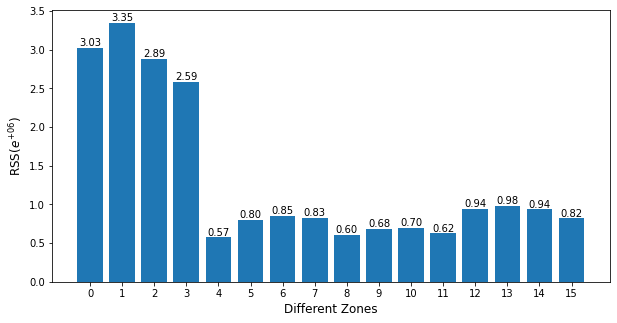

In [73]:
rsses = []
for col in range(3, 19):
    rss = np.nansum((np_all[:,2] - np_all[:,col])**2)
    rsses.append(rss)
rsses = np.array(rsses)
rsses = rsses/1000000
plt.rcParams["figure.figsize"] = (10, 5)
fig, ax = plt.subplots()
ax.bar(range(len(rsses)), rsses)
ax.bar_label(ax.containers[0], fmt= "%.2f")
plt.ylabel("RSS($e^{+06}$)", fontsize=12)
plt.xlabel("Different Zones", fontsize=12)
plt.xticks(range(len(rsses)))

# plt.grid(True)
